In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'normalized','im':'t1','fe':['b25'],'fi':['t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_md',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_md_data_norm_b25_t1_mask_t1_normalized_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_1_42_n_normalized_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(734160, 920)
(734160, 1)
validation
(101248, 920)
(101248, 1)
test
(100432, 920)
(100432, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 920)]             0         


 dense (Dense)               (None, 1024)              943104    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1632257 (6.23 MB)


Trainable params: 1632257 (6.23 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/74 [..............................] - ETA: 1:43 - loss: 0.0519 - STD: 1.7222e-04 - MAE: 0.2192

 5/74 [=>............................] - ETA: 1s - loss: 0.0297 - STD: 3.7451e-04 - MAE: 0.1324  

 8/74 [==>...........................] - ETA: 1s - loss: 0.0263 - STD: 3.8173e-04 - MAE: 0.1186

11/74 [===>..........................] - ETA: 1s - loss: 0.0227 - STD: 4.7509e-04 - MAE: 0.1088

14/74 [====>.........................] - ETA: 1s - loss: 0.0215 - STD: 5.6981e-04 - MAE: 0.1102

17/74 [=====>........................] - ETA: 1s - loss: 0.0199 - STD: 6.4052e-04 - MAE: 0.1042

19/74 [======>.......................] - ETA: 1s - loss: 0.0191 - STD: 6.7514e-04 - MAE: 0.0995

22/74 [=======>......................] - ETA: 1s - loss: 0.0185 - STD: 7.2699e-04 - MAE: 0.0946

25/74 [=========>....................] - ETA: 1s - loss: 0.0177 - STD: 7.9746e-04 - MAE: 0.0906

28/74 [==========>...................] - ETA: 0s - loss: 0.0171 - STD: 8.9002e-04 - MAE: 0.0892

31/74 [===========>..................] - ETA: 0s - loss: 0.0167 - STD: 9.9635e-04 - MAE: 0.0889

34/74 [============>.................] - ETA: 0s - loss: 0.0162 - STD: 0.0011 - MAE: 0.0874    

37/74 [==============>...............] - ETA: 0s - loss: 0.0159 - STD: 0.0012 - MAE: 0.0853

40/74 [===============>..............] - ETA: 0s - loss: 0.0156 - STD: 0.0014 - MAE: 0.0835

43/74 [================>.............] - ETA: 0s - loss: 0.0153 - STD: 0.0016 - MAE: 0.0823

45/74 [=================>............] - ETA: 0s - loss: 0.0151 - STD: 0.0017 - MAE: 0.0820

47/74 [==================>...........] - ETA: 0s - loss: 0.0150 - STD: 0.0019 - MAE: 0.0817

49/74 [==================>...........] - ETA: 0s - loss: 0.0149 - STD: 0.0021 - MAE: 0.0812

51/74 [===================>..........] - ETA: 0s - loss: 0.0147 - STD: 0.0023 - MAE: 0.0805

54/74 [====================>.........] - ETA: 0s - loss: 0.0145 - STD: 0.0028 - MAE: 0.0793

56/74 [=====================>........] - ETA: 0s - loss: 0.0143 - STD: 0.0031 - MAE: 0.0786

58/74 [======================>.......] - ETA: 0s - loss: 0.0142 - STD: 0.0036 - MAE: 0.0781

60/74 [=======================>......] - ETA: 0s - loss: 0.0140 - STD: 0.0041 - MAE: 0.0776

62/74 [========================>.....] - ETA: 0s - loss: 0.0138 - STD: 0.0047 - MAE: 0.0771

64/74 [========================>.....] - ETA: 0s - loss: 0.0137 - STD: 0.0055 - MAE: 0.0764

66/74 [=========================>....] - ETA: 0s - loss: 0.0135 - STD: 0.0063 - MAE: 0.0756

68/74 [==========================>...] - ETA: 0s - loss: 0.0133 - STD: 0.0074 - MAE: 0.0749

71/74 [===========================>..] - ETA: 0s - loss: 0.0129 - STD: 0.0093 - MAE: 0.0737

74/74 [==============================] - ETA: 0s - loss: 0.0126 - STD: 0.0116 - MAE: 0.0724

74/74 [==============================] - 4s 42ms/step - loss: 0.0126 - STD: 0.0116 - MAE: 0.0724 - val_loss: 0.0049 - val_STD: 0.0500 - val_MAE: 0.0420


Epoch 2/10000


 1/74 [..............................] - ETA: 5s - loss: 0.0042 - STD: 0.0731 - MAE: 0.0411

 3/74 [>.............................] - ETA: 2s - loss: 0.0041 - STD: 0.0766 - MAE: 0.0411

 5/74 [=>............................] - ETA: 2s - loss: 0.0039 - STD: 0.0799 - MAE: 0.0404

 7/74 [=>............................] - ETA: 1s - loss: 0.0038 - STD: 0.0815 - MAE: 0.0397

10/74 [===>..........................] - ETA: 1s - loss: 0.0036 - STD: 0.0832 - MAE: 0.0387

13/74 [====>.........................] - ETA: 1s - loss: 0.0035 - STD: 0.0841 - MAE: 0.0379

16/74 [=====>........................] - ETA: 1s - loss: 0.0034 - STD: 0.0853 - MAE: 0.0373

19/74 [======>.......................] - ETA: 1s - loss: 0.0033 - STD: 0.0865 - MAE: 0.0368

21/74 [=======>......................] - ETA: 1s - loss: 0.0032 - STD: 0.0873 - MAE: 0.0366

24/74 [========>.....................] - ETA: 1s - loss: 0.0032 - STD: 0.0886 - MAE: 0.0363

27/74 [=========>....................] - ETA: 1s - loss: 0.0032 - STD: 0.0892 - MAE: 0.0361

30/74 [===========>..................] - ETA: 1s - loss: 0.0031 - STD: 0.0898 - MAE: 0.0359

33/74 [============>.................] - ETA: 0s - loss: 0.0031 - STD: 0.0902 - MAE: 0.0357

35/74 [=============>................] - ETA: 0s - loss: 0.0031 - STD: 0.0905 - MAE: 0.0356

38/74 [==============>...............] - ETA: 0s - loss: 0.0031 - STD: 0.0910 - MAE: 0.0355

41/74 [===============>..............] - ETA: 0s - loss: 0.0030 - STD: 0.0914 - MAE: 0.0354

44/74 [================>.............] - ETA: 0s - loss: 0.0030 - STD: 0.0917 - MAE: 0.0353

46/74 [=================>............] - ETA: 0s - loss: 0.0030 - STD: 0.0919 - MAE: 0.0353

49/74 [==================>...........] - ETA: 0s - loss: 0.0030 - STD: 0.0921 - MAE: 0.0352

52/74 [====================>.........] - ETA: 0s - loss: 0.0030 - STD: 0.0923 - MAE: 0.0351

55/74 [=====================>........] - ETA: 0s - loss: 0.0029 - STD: 0.0925 - MAE: 0.0350

58/74 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0928 - MAE: 0.0349

60/74 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0928 - MAE: 0.0348

62/74 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0929 - MAE: 0.0348

65/74 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0932 - MAE: 0.0347

68/74 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0932 - MAE: 0.0346

70/74 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0934 - MAE: 0.0346

73/74 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0935 - MAE: 0.0345

74/74 [==============================] - 2s 28ms/step - loss: 0.0028 - STD: 0.0935 - MAE: 0.0345 - val_loss: 0.0027 - val_STD: 0.0745 - val_MAE: 0.0339


Epoch 3/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0027 - STD: 0.0963 - MAE: 0.0335

 3/74 [>.............................] - ETA: 2s - loss: 0.0025 - STD: 0.0965 - MAE: 0.0327

 5/74 [=>............................] - ETA: 1s - loss: 0.0025 - STD: 0.0967 - MAE: 0.0327

 7/74 [=>............................] - ETA: 1s - loss: 0.0025 - STD: 0.0968 - MAE: 0.0327

 9/74 [==>...........................] - ETA: 1s - loss: 0.0025 - STD: 0.0969 - MAE: 0.0326

11/74 [===>..........................] - ETA: 1s - loss: 0.0025 - STD: 0.0967 - MAE: 0.0326

13/74 [====>.........................] - ETA: 1s - loss: 0.0025 - STD: 0.0968 - MAE: 0.0325

16/74 [=====>........................] - ETA: 1s - loss: 0.0025 - STD: 0.0966 - MAE: 0.0326

19/74 [======>.......................] - ETA: 1s - loss: 0.0024 - STD: 0.0969 - MAE: 0.0325

21/74 [=======>......................] - ETA: 1s - loss: 0.0025 - STD: 0.0965 - MAE: 0.0325

23/74 [========>.....................] - ETA: 1s - loss: 0.0024 - STD: 0.0969 - MAE: 0.0325

25/74 [=========>....................] - ETA: 1s - loss: 0.0024 - STD: 0.0970 - MAE: 0.0325

27/74 [=========>....................] - ETA: 1s - loss: 0.0024 - STD: 0.0970 - MAE: 0.0325

29/74 [==========>...................] - ETA: 1s - loss: 0.0024 - STD: 0.0972 - MAE: 0.0325

31/74 [===========>..................] - ETA: 1s - loss: 0.0024 - STD: 0.0971 - MAE: 0.0324

33/74 [============>.................] - ETA: 1s - loss: 0.0024 - STD: 0.0972 - MAE: 0.0324

36/74 [=============>................] - ETA: 1s - loss: 0.0024 - STD: 0.0971 - MAE: 0.0324

39/74 [==============>...............] - ETA: 0s - loss: 0.0024 - STD: 0.0971 - MAE: 0.0323

42/74 [================>.............] - ETA: 0s - loss: 0.0024 - STD: 0.0971 - MAE: 0.0323

44/74 [================>.............] - ETA: 0s - loss: 0.0024 - STD: 0.0971 - MAE: 0.0322

47/74 [==================>...........] - ETA: 0s - loss: 0.0024 - STD: 0.0971 - MAE: 0.0322

50/74 [===================>..........] - ETA: 0s - loss: 0.0024 - STD: 0.0972 - MAE: 0.0321

53/74 [====================>.........] - ETA: 0s - loss: 0.0024 - STD: 0.0972 - MAE: 0.0321

56/74 [=====================>........] - ETA: 0s - loss: 0.0024 - STD: 0.0972 - MAE: 0.0320

59/74 [======================>.......] - ETA: 0s - loss: 0.0024 - STD: 0.0971 - MAE: 0.0320

62/74 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0972 - MAE: 0.0319

65/74 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.0973 - MAE: 0.0319

67/74 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0973 - MAE: 0.0319

70/74 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0974 - MAE: 0.0319

73/74 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0975 - MAE: 0.0318

74/74 [==============================] - 2s 30ms/step - loss: 0.0023 - STD: 0.0975 - MAE: 0.0318 - val_loss: 0.0024 - val_STD: 0.0745 - val_MAE: 0.0313


Epoch 4/10000


 1/74 [..............................] - ETA: 5s - loss: 0.0022 - STD: 0.0955 - MAE: 0.0310

 3/74 [>.............................] - ETA: 2s - loss: 0.0023 - STD: 0.0983 - MAE: 0.0311

 5/74 [=>............................] - ETA: 1s - loss: 0.0022 - STD: 0.0977 - MAE: 0.0310

 8/74 [==>...........................] - ETA: 1s - loss: 0.0022 - STD: 0.0978 - MAE: 0.0308

10/74 [===>..........................] - ETA: 1s - loss: 0.0022 - STD: 0.0981 - MAE: 0.0307

12/74 [===>..........................] - ETA: 1s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0307

15/74 [=====>........................] - ETA: 1s - loss: 0.0022 - STD: 0.0984 - MAE: 0.0307

18/74 [======>.......................] - ETA: 1s - loss: 0.0022 - STD: 0.0983 - MAE: 0.0306

21/74 [=======>......................] - ETA: 1s - loss: 0.0022 - STD: 0.0982 - MAE: 0.0306

24/74 [========>.....................] - ETA: 1s - loss: 0.0021 - STD: 0.0979 - MAE: 0.0306

27/74 [=========>....................] - ETA: 1s - loss: 0.0021 - STD: 0.0979 - MAE: 0.0305

30/74 [===========>..................] - ETA: 0s - loss: 0.0021 - STD: 0.0979 - MAE: 0.0305

32/74 [===========>..................] - ETA: 0s - loss: 0.0021 - STD: 0.0980 - MAE: 0.0304

34/74 [============>.................] - ETA: 0s - loss: 0.0021 - STD: 0.0980 - MAE: 0.0304

36/74 [=============>................] - ETA: 0s - loss: 0.0021 - STD: 0.0982 - MAE: 0.0304

38/74 [==============>...............] - ETA: 0s - loss: 0.0021 - STD: 0.0983 - MAE: 0.0303

41/74 [===============>..............] - ETA: 0s - loss: 0.0021 - STD: 0.0984 - MAE: 0.0303

44/74 [================>.............] - ETA: 0s - loss: 0.0021 - STD: 0.0985 - MAE: 0.0303

46/74 [=================>............] - ETA: 0s - loss: 0.0021 - STD: 0.0986 - MAE: 0.0303

48/74 [==================>...........] - ETA: 0s - loss: 0.0021 - STD: 0.0987 - MAE: 0.0302

50/74 [===================>..........] - ETA: 0s - loss: 0.0021 - STD: 0.0987 - MAE: 0.0302

52/74 [====================>.........] - ETA: 0s - loss: 0.0021 - STD: 0.0987 - MAE: 0.0302

54/74 [====================>.........] - ETA: 0s - loss: 0.0021 - STD: 0.0988 - MAE: 0.0302

56/74 [=====================>........] - ETA: 0s - loss: 0.0021 - STD: 0.0987 - MAE: 0.0302

58/74 [======================>.......] - ETA: 0s - loss: 0.0021 - STD: 0.0987 - MAE: 0.0302

60/74 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.0988 - MAE: 0.0302

62/74 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.0988 - MAE: 0.0302

64/74 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0302

66/74 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0302

68/74 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0301

71/74 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0301

74/74 [==============================] - ETA: 0s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0301

74/74 [==============================] - 2s 29ms/step - loss: 0.0021 - STD: 0.0989 - MAE: 0.0301 - val_loss: 0.0022 - val_STD: 0.0757 - val_MAE: 0.0305


Epoch 5/10000


 1/74 [..............................] - ETA: 5s - loss: 0.0020 - STD: 0.0972 - MAE: 0.0300

 4/74 [>.............................] - ETA: 1s - loss: 0.0020 - STD: 0.0987 - MAE: 0.0298

 6/74 [=>............................] - ETA: 1s - loss: 0.0020 - STD: 0.0993 - MAE: 0.0296

 8/74 [==>...........................] - ETA: 1s - loss: 0.0020 - STD: 0.0986 - MAE: 0.0297

10/74 [===>..........................] - ETA: 1s - loss: 0.0020 - STD: 0.0985 - MAE: 0.0297

12/74 [===>..........................] - ETA: 1s - loss: 0.0020 - STD: 0.0988 - MAE: 0.0297

15/74 [=====>........................] - ETA: 1s - loss: 0.0020 - STD: 0.0985 - MAE: 0.0295

18/74 [======>.......................] - ETA: 1s - loss: 0.0019 - STD: 0.0985 - MAE: 0.0294

21/74 [=======>......................] - ETA: 1s - loss: 0.0019 - STD: 0.0989 - MAE: 0.0294

24/74 [========>.....................] - ETA: 1s - loss: 0.0019 - STD: 0.0989 - MAE: 0.0293

27/74 [=========>....................] - ETA: 1s - loss: 0.0019 - STD: 0.0990 - MAE: 0.0293

29/74 [==========>...................] - ETA: 1s - loss: 0.0019 - STD: 0.0990 - MAE: 0.0292

31/74 [===========>..................] - ETA: 1s - loss: 0.0019 - STD: 0.0991 - MAE: 0.0292

33/74 [============>.................] - ETA: 1s - loss: 0.0019 - STD: 0.0991 - MAE: 0.0292

35/74 [=============>................] - ETA: 1s - loss: 0.0019 - STD: 0.0993 - MAE: 0.0292

38/74 [==============>...............] - ETA: 0s - loss: 0.0019 - STD: 0.0995 - MAE: 0.0292

41/74 [===============>..............] - ETA: 0s - loss: 0.0019 - STD: 0.0996 - MAE: 0.0291

44/74 [================>.............] - ETA: 0s - loss: 0.0019 - STD: 0.0997 - MAE: 0.0291

47/74 [==================>...........] - ETA: 0s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0291

50/74 [===================>..........] - ETA: 0s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0291

53/74 [====================>.........] - ETA: 0s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0291

56/74 [=====================>........] - ETA: 0s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0291

59/74 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0290

61/74 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0290

63/74 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0290

65/74 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0290

67/74 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0290

70/74 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0289

73/74 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0289

74/74 [==============================] - 2s 29ms/step - loss: 0.0019 - STD: 0.0999 - MAE: 0.0289 - val_loss: 0.0021 - val_STD: 0.0804 - val_MAE: 0.0312


Epoch 6/10000


 1/74 [..............................] - ETA: 5s - loss: 0.0018 - STD: 0.1013 - MAE: 0.0285

 4/74 [>.............................] - ETA: 1s - loss: 0.0018 - STD: 0.1018 - MAE: 0.0286

 6/74 [=>............................] - ETA: 1s - loss: 0.0019 - STD: 0.1007 - MAE: 0.0292

 9/74 [==>...........................] - ETA: 1s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0289

12/74 [===>..........................] - ETA: 1s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0289

16/74 [=====>........................] - ETA: 1s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0287

19/74 [======>.......................] - ETA: 1s - loss: 0.0018 - STD: 0.1003 - MAE: 0.0286

22/74 [=======>......................] - ETA: 1s - loss: 0.0018 - STD: 0.1003 - MAE: 0.0285

25/74 [=========>....................] - ETA: 1s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0285

27/74 [=========>....................] - ETA: 1s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0285

29/74 [==========>...................] - ETA: 1s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0285

32/74 [===========>..................] - ETA: 1s - loss: 0.0018 - STD: 0.1003 - MAE: 0.0285

35/74 [=============>................] - ETA: 0s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0284

37/74 [==============>...............] - ETA: 0s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0284

39/74 [==============>...............] - ETA: 0s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0284

42/74 [================>.............] - ETA: 0s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0284

44/74 [================>.............] - ETA: 0s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0283

47/74 [==================>...........] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0284

49/74 [==================>...........] - ETA: 0s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0285

51/74 [===================>..........] - ETA: 0s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0285

53/74 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0285

55/74 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0286

57/74 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0286

59/74 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0286

61/74 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0285

64/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0285

67/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0285

70/74 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0285

73/74 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0285

74/74 [==============================] - 2s 29ms/step - loss: 0.0018 - STD: 0.1005 - MAE: 0.0285 - val_loss: 0.0019 - val_STD: 0.0788 - val_MAE: 0.0296


Epoch 7/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0279

 3/74 [>.............................] - ETA: 1s - loss: 0.0018 - STD: 0.1020 - MAE: 0.0282

 5/74 [=>............................] - ETA: 1s - loss: 0.0017 - STD: 0.1022 - MAE: 0.0282

 8/74 [==>...........................] - ETA: 1s - loss: 0.0017 - STD: 0.1022 - MAE: 0.0282

10/74 [===>..........................] - ETA: 1s - loss: 0.0018 - STD: 0.1022 - MAE: 0.0283

13/74 [====>.........................] - ETA: 1s - loss: 0.0017 - STD: 0.1019 - MAE: 0.0282

15/74 [=====>........................] - ETA: 1s - loss: 0.0017 - STD: 0.1018 - MAE: 0.0282

18/74 [======>.......................] - ETA: 1s - loss: 0.0018 - STD: 0.1014 - MAE: 0.0284

21/74 [=======>......................] - ETA: 1s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0284

24/74 [========>.....................] - ETA: 1s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0284

26/74 [=========>....................] - ETA: 1s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0283

28/74 [==========>...................] - ETA: 1s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0282

30/74 [===========>..................] - ETA: 1s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0283

33/74 [============>.................] - ETA: 1s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0285

36/74 [=============>................] - ETA: 0s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0285

38/74 [==============>...............] - ETA: 0s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0285

40/74 [===============>..............] - ETA: 0s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0285

43/74 [================>.............] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0285

45/74 [=================>............] - ETA: 0s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0285

48/74 [==================>...........] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0284

50/74 [===================>..........] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0284

53/74 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0283

56/74 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0283

59/74 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0283

62/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0283

64/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0283

66/74 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0283

69/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0283

72/74 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0283

74/74 [==============================] - 2s 28ms/step - loss: 0.0018 - STD: 0.1009 - MAE: 0.0283 - val_loss: 0.0021 - val_STD: 0.0811 - val_MAE: 0.0314


Epoch 8/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0017 - STD: 0.1000 - MAE: 0.0280

 3/74 [>.............................] - ETA: 2s - loss: 0.0018 - STD: 0.0994 - MAE: 0.0284

 5/74 [=>............................] - ETA: 2s - loss: 0.0017 - STD: 0.0996 - MAE: 0.0281

 7/74 [=>............................] - ETA: 1s - loss: 0.0017 - STD: 0.1003 - MAE: 0.0282

 9/74 [==>...........................] - ETA: 2s - loss: 0.0017 - STD: 0.1007 - MAE: 0.0280

11/74 [===>..........................] - ETA: 1s - loss: 0.0017 - STD: 0.1000 - MAE: 0.0279

14/74 [====>.........................] - ETA: 1s - loss: 0.0017 - STD: 0.0999 - MAE: 0.0279

17/74 [=====>........................] - ETA: 1s - loss: 0.0017 - STD: 0.0999 - MAE: 0.0282

19/74 [======>.......................] - ETA: 1s - loss: 0.0017 - STD: 0.1003 - MAE: 0.0283

22/74 [=======>......................] - ETA: 1s - loss: 0.0018 - STD: 0.1001 - MAE: 0.0286

25/74 [=========>....................] - ETA: 1s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0285

27/74 [=========>....................] - ETA: 1s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0284

29/74 [==========>...................] - ETA: 1s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0284

31/74 [===========>..................] - ETA: 1s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0283

33/74 [============>.................] - ETA: 1s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0283

36/74 [=============>................] - ETA: 0s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0283

39/74 [==============>...............] - ETA: 0s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0282

41/74 [===============>..............] - ETA: 0s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0282

43/74 [================>.............] - ETA: 0s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0282

46/74 [=================>............] - ETA: 0s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0281

49/74 [==================>...........] - ETA: 0s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0281

52/74 [====================>.........] - ETA: 0s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0281

54/74 [====================>.........] - ETA: 0s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0281

57/74 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0280

59/74 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0280

61/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0280

64/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0280

67/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0280

69/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0280

71/74 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0281

74/74 [==============================] - 2s 29ms/step - loss: 0.0017 - STD: 0.1010 - MAE: 0.0281 - val_loss: 0.0020 - val_STD: 0.0817 - val_MAE: 0.0309


Epoch 9/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0018 - STD: 0.1014 - MAE: 0.0286

 4/74 [>.............................] - ETA: 1s - loss: 0.0017 - STD: 0.1024 - MAE: 0.0276

 8/74 [==>...........................] - ETA: 1s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0275

11/74 [===>..........................] - ETA: 1s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0274

14/74 [====>.........................] - ETA: 1s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0274

17/74 [=====>........................] - ETA: 1s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0275

20/74 [=======>......................] - ETA: 1s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0276

23/74 [========>.....................] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0276

26/74 [=========>....................] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0277

29/74 [==========>...................] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0277

32/74 [===========>..................] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0276

35/74 [=============>................] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0276

38/74 [==============>...............] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0277

41/74 [===============>..............] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0278

44/74 [================>.............] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0280

47/74 [==================>...........] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0281

50/74 [===================>..........] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0281

53/74 [====================>.........] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0281

56/74 [=====================>........] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0281

59/74 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0280

62/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0280

65/74 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0280

68/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0280

71/74 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0279

74/74 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0279

74/74 [==============================] - 2s 22ms/step - loss: 0.0017 - STD: 0.1012 - MAE: 0.0279 - val_loss: 0.0020 - val_STD: 0.0817 - val_MAE: 0.0303


Epoch 10/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0016 - STD: 0.1043 - MAE: 0.0272

 4/74 [>.............................] - ETA: 1s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0274

 7/74 [=>............................] - ETA: 1s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0277

10/74 [===>..........................] - ETA: 1s - loss: 0.0016 - STD: 0.1012 - MAE: 0.0275

13/74 [====>.........................] - ETA: 1s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0275

17/74 [=====>........................] - ETA: 0s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0275

20/74 [=======>......................] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0274

23/74 [========>.....................] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0274

26/74 [=========>....................] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0274

29/74 [==========>...................] - ETA: 0s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0275

32/74 [===========>..................] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0275

35/74 [=============>................] - ETA: 0s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0277

38/74 [==============>...............] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0277

41/74 [===============>..............] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0277

44/74 [================>.............] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0277

47/74 [==================>...........] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0277

50/74 [===================>..........] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0277

53/74 [====================>.........] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0276

56/74 [=====================>........] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0277

59/74 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0276

62/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0276

65/74 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0276

68/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0276

71/74 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0277

74/74 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0277

74/74 [==============================] - 2s 21ms/step - loss: 0.0017 - STD: 0.1015 - MAE: 0.0277 - val_loss: 0.0023 - val_STD: 0.0842 - val_MAE: 0.0330


Epoch 11/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0019 - STD: 0.1078 - MAE: 0.0293

 4/74 [>.............................] - ETA: 1s - loss: 0.0017 - STD: 0.1033 - MAE: 0.0279

 7/74 [=>............................] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0283

10/74 [===>..........................] - ETA: 1s - loss: 0.0017 - STD: 0.1018 - MAE: 0.0281

13/74 [====>.........................] - ETA: 1s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0279

16/74 [=====>........................] - ETA: 1s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0279

19/74 [======>.......................] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0279

22/74 [=======>......................] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0279

25/74 [=========>....................] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0278

28/74 [==========>...................] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0278

31/74 [===========>..................] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0278

34/74 [============>.................] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0278

37/74 [==============>...............] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0277

41/74 [===============>..............] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0276

44/74 [================>.............] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0277

47/74 [==================>...........] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0277

50/74 [===================>..........] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0277

53/74 [====================>.........] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0277

56/74 [=====================>........] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0277

59/74 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0277

62/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0276

65/74 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0276

68/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0276

71/74 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0276

74/74 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0276

74/74 [==============================] - 2s 21ms/step - loss: 0.0017 - STD: 0.1015 - MAE: 0.0276 - val_loss: 0.0020 - val_STD: 0.0832 - val_MAE: 0.0299


Epoch 12/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0016 - STD: 0.1064 - MAE: 0.0270

 4/74 [>.............................] - ETA: 1s - loss: 0.0016 - STD: 0.1036 - MAE: 0.0271

 7/74 [=>............................] - ETA: 1s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0274

11/74 [===>..........................] - ETA: 1s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0273

14/74 [====>.........................] - ETA: 1s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0273

17/74 [=====>........................] - ETA: 1s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0275

20/74 [=======>......................] - ETA: 1s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0274

23/74 [========>.....................] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0274

26/74 [=========>....................] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0273

29/74 [==========>...................] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0273

32/74 [===========>..................] - ETA: 0s - loss: 0.0016 - STD: 0.1013 - MAE: 0.0273

35/74 [=============>................] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0273

38/74 [==============>...............] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0273

41/74 [===============>..............] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0273

44/74 [================>.............] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0273

47/74 [==================>...........] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0273

50/74 [===================>..........] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0273

53/74 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0273

56/74 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0273

59/74 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0273

62/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0273

65/74 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0274

68/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0273

71/74 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0273

74/74 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0273

74/74 [==============================] - 2s 22ms/step - loss: 0.0016 - STD: 0.1017 - MAE: 0.0273 - val_loss: 0.0021 - val_STD: 0.0836 - val_MAE: 0.0319


Epoch 13/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0017 - STD: 0.1027 - MAE: 0.0282

 4/74 [>.............................] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0282

 7/74 [=>............................] - ETA: 1s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0281

10/74 [===>..........................] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0279

13/74 [====>.........................] - ETA: 1s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0281

16/74 [=====>........................] - ETA: 1s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0278

19/74 [======>.......................] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0277

22/74 [=======>......................] - ETA: 1s - loss: 0.0016 - STD: 0.1012 - MAE: 0.0276

25/74 [=========>....................] - ETA: 0s - loss: 0.0016 - STD: 0.1013 - MAE: 0.0276

28/74 [==========>...................] - ETA: 0s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0275

31/74 [===========>..................] - ETA: 0s - loss: 0.0016 - STD: 0.1012 - MAE: 0.0274

34/74 [============>.................] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0274

37/74 [==============>...............] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0274

41/74 [===============>..............] - ETA: 0s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0274

44/74 [================>.............] - ETA: 0s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0275

47/74 [==================>...........] - ETA: 0s - loss: 0.0016 - STD: 0.1013 - MAE: 0.0276

50/74 [===================>..........] - ETA: 0s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0275

53/74 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0275

56/74 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0275

59/74 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0274

62/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0274

65/74 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0274

68/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0274

71/74 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0273

74/74 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0273

74/74 [==============================] - 2s 22ms/step - loss: 0.0016 - STD: 0.1017 - MAE: 0.0273 - val_loss: 0.0018 - val_STD: 0.0819 - val_MAE: 0.0279


Epoch 14/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0015 - STD: 0.1013 - MAE: 0.0269

 4/74 [>.............................] - ETA: 1s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0270

 7/74 [=>............................] - ETA: 1s - loss: 0.0015 - STD: 0.1014 - MAE: 0.0267

 9/74 [==>...........................] - ETA: 1s - loss: 0.0015 - STD: 0.1014 - MAE: 0.0270

12/74 [===>..........................] - ETA: 1s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0274

15/74 [=====>........................] - ETA: 1s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0273

18/74 [======>.......................] - ETA: 1s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0272

21/74 [=======>......................] - ETA: 1s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0271

24/74 [========>.....................] - ETA: 0s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0271

27/74 [=========>....................] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0271

30/74 [===========>..................] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0271

33/74 [============>.................] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0272

36/74 [=============>................] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0274

39/74 [==============>...............] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0274

42/74 [================>.............] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0273

45/74 [=================>............] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0274

48/74 [==================>...........] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0274

51/74 [===================>..........] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0274

54/74 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0274

57/74 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0274

60/74 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0274

63/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0274

66/74 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0273

69/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0273

72/74 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0273

74/74 [==============================] - 2s 22ms/step - loss: 0.0016 - STD: 0.1018 - MAE: 0.0273 - val_loss: 0.0021 - val_STD: 0.0828 - val_MAE: 0.0312


Epoch 15/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0015 - STD: 0.1037 - MAE: 0.0271

 4/74 [>.............................] - ETA: 1s - loss: 0.0017 - STD: 0.1018 - MAE: 0.0282

 7/74 [=>............................] - ETA: 1s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0278

10/74 [===>..........................] - ETA: 1s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0278

13/74 [====>.........................] - ETA: 1s - loss: 0.0017 - STD: 0.1023 - MAE: 0.0278

16/74 [=====>........................] - ETA: 1s - loss: 0.0017 - STD: 0.1020 - MAE: 0.0277

19/74 [======>.......................] - ETA: 1s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0276

22/74 [=======>......................] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0275

25/74 [=========>....................] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0275

28/74 [==========>...................] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0274

31/74 [===========>..................] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0273

34/74 [============>.................] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0273

37/74 [==============>...............] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0272

40/74 [===============>..............] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0273

43/74 [================>.............] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0272

46/74 [=================>............] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0272

49/74 [==================>...........] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0272

52/74 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0272

55/74 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0271

58/74 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0272

61/74 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0272

64/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0271

67/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0271

70/74 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0271

73/74 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0271

74/74 [==============================] - 2s 22ms/step - loss: 0.0016 - STD: 0.1019 - MAE: 0.0271 - val_loss: 0.0017 - val_STD: 0.0803 - val_MAE: 0.0275


Epoch 16/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0267

 4/74 [>.............................] - ETA: 1s - loss: 0.0016 - STD: 0.1025 - MAE: 0.0268

 7/74 [=>............................] - ETA: 1s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0268

10/74 [===>..........................] - ETA: 1s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0267

13/74 [====>.........................] - ETA: 1s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0267

16/74 [=====>........................] - ETA: 1s - loss: 0.0015 - STD: 0.1029 - MAE: 0.0267

19/74 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0267

22/74 [=======>......................] - ETA: 0s - loss: 0.0015 - STD: 0.1028 - MAE: 0.0267

25/74 [=========>....................] - ETA: 0s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0267

28/74 [==========>...................] - ETA: 0s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0267

31/74 [===========>..................] - ETA: 0s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0267

34/74 [============>.................] - ETA: 0s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0267

37/74 [==============>...............] - ETA: 0s - loss: 0.0016 - STD: 0.1025 - MAE: 0.0269

40/74 [===============>..............] - ETA: 0s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0270

43/74 [================>.............] - ETA: 0s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0271

46/74 [=================>............] - ETA: 0s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0270

49/74 [==================>...........] - ETA: 0s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0271

52/74 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0271

55/74 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0271

58/74 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0271

61/74 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0270

64/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0270

67/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0270

70/74 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0270

73/74 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0269

74/74 [==============================] - 2s 22ms/step - loss: 0.0016 - STD: 0.1020 - MAE: 0.0269 - val_loss: 0.0019 - val_STD: 0.0840 - val_MAE: 0.0296


Epoch 17/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0016 - STD: 0.1058 - MAE: 0.0269

 4/74 [>.............................] - ETA: 1s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0279

 7/74 [=>............................] - ETA: 1s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0282

10/74 [===>..........................] - ETA: 1s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0278

13/74 [====>.........................] - ETA: 1s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0276

16/74 [=====>........................] - ETA: 1s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0274

19/74 [======>.......................] - ETA: 1s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0273

22/74 [=======>......................] - ETA: 1s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0271

25/74 [=========>....................] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0270

28/74 [==========>...................] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0269

31/74 [===========>..................] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0269

34/74 [============>.................] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0268

37/74 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0268

40/74 [===============>..............] - ETA: 0s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0268

43/74 [================>.............] - ETA: 0s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0269

46/74 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0269

49/74 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0268

52/74 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0269

56/74 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0270

59/74 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0270

62/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0270

65/74 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0270

68/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0269

71/74 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0269

74/74 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0269

74/74 [==============================] - 2s 22ms/step - loss: 0.0016 - STD: 0.1021 - MAE: 0.0269 - val_loss: 0.0019 - val_STD: 0.0833 - val_MAE: 0.0294


Epoch 18/10000


 1/74 [..............................] - ETA: 1s - loss: 0.0016 - STD: 0.1098 - MAE: 0.0275

 4/74 [>.............................] - ETA: 1s - loss: 0.0016 - STD: 0.1059 - MAE: 0.0271

 7/74 [=>............................] - ETA: 1s - loss: 0.0015 - STD: 0.1040 - MAE: 0.0270

10/74 [===>..........................] - ETA: 1s - loss: 0.0015 - STD: 0.1030 - MAE: 0.0268

13/74 [====>.........................] - ETA: 1s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0270

16/74 [=====>........................] - ETA: 1s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0271

19/74 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0269

22/74 [=======>......................] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0268

25/74 [=========>....................] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0268

28/74 [==========>...................] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0267

31/74 [===========>..................] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0267

34/74 [============>.................] - ETA: 0s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0268

37/74 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0269

40/74 [===============>..............] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0269

43/74 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0269

46/74 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0269

49/74 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0269

52/74 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0269

55/74 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0268

58/74 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0269

61/74 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0268

64/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0268

67/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0268

70/74 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0268

73/74 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0268

74/74 [==============================] - 2s 21ms/step - loss: 0.0015 - STD: 0.1022 - MAE: 0.0268 - val_loss: 0.0019 - val_STD: 0.0765 - val_MAE: 0.0293


Epoch 19/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0021 - STD: 0.0976 - MAE: 0.0327

 4/74 [>.............................] - ETA: 1s - loss: 0.0020 - STD: 0.1019 - MAE: 0.0318

 7/74 [=>............................] - ETA: 1s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0295

10/74 [===>..........................] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0284

13/74 [====>.........................] - ETA: 1s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0280

16/74 [=====>........................] - ETA: 1s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0277

19/74 [======>.......................] - ETA: 1s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0275

22/74 [=======>......................] - ETA: 1s - loss: 0.0016 - STD: 0.1013 - MAE: 0.0274

25/74 [=========>....................] - ETA: 0s - loss: 0.0016 - STD: 0.1013 - MAE: 0.0273

28/74 [==========>...................] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0272

31/74 [===========>..................] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0271

34/74 [============>.................] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0270

37/74 [==============>...............] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0270

40/74 [===============>..............] - ETA: 0s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0270

43/74 [================>.............] - ETA: 0s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0270

46/74 [=================>............] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0270

49/74 [==================>...........] - ETA: 0s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0272

52/74 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0272

55/74 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0272

58/74 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0272

61/74 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0271

64/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0271

67/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0271

70/74 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0270

73/74 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0270

74/74 [==============================] - 2s 22ms/step - loss: 0.0016 - STD: 0.1019 - MAE: 0.0270 - val_loss: 0.0018 - val_STD: 0.0832 - val_MAE: 0.0287


Epoch 20/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0014 - STD: 0.1018 - MAE: 0.0255

 4/74 [>.............................] - ETA: 1s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0262

 7/74 [=>............................] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0264

10/74 [===>..........................] - ETA: 1s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0263

13/74 [====>.........................] - ETA: 1s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0263

16/74 [=====>........................] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0263

19/74 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0262

23/74 [========>.....................] - ETA: 0s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0263

27/74 [=========>....................] - ETA: 0s - loss: 0.0015 - STD: 0.1017 - MAE: 0.0263

30/74 [===========>..................] - ETA: 0s - loss: 0.0015 - STD: 0.1017 - MAE: 0.0264

33/74 [============>.................] - ETA: 0s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0267

36/74 [=============>................] - ETA: 0s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0266

39/74 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0265

42/74 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0265

45/74 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0265

48/74 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0265

51/74 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0265

54/74 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0265

57/74 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0266

60/74 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0267

63/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0267

66/74 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0266

69/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0266

72/74 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0266

74/74 [==============================] - 2s 22ms/step - loss: 0.0015 - STD: 0.1022 - MAE: 0.0266 - val_loss: 0.0018 - val_STD: 0.0825 - val_MAE: 0.0278


Epoch 21/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0262

 4/74 [>.............................] - ETA: 1s - loss: 0.0015 - STD: 0.1034 - MAE: 0.0267

 7/74 [=>............................] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0265

10/74 [===>..........................] - ETA: 1s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0264

13/74 [====>.........................] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0264

16/74 [=====>........................] - ETA: 1s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0264

19/74 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0264

23/74 [========>.....................] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0264

26/74 [=========>....................] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0263

29/74 [==========>...................] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0264

32/74 [===========>..................] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0265

35/74 [=============>................] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0264

38/74 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0264

41/74 [===============>..............] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0264

44/74 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0263

47/74 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0263

50/74 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0263

53/74 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0263

56/74 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0264

59/74 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0267

62/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0268

66/74 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0268

69/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0268

72/74 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0268

74/74 [==============================] - 2s 21ms/step - loss: 0.0015 - STD: 0.1022 - MAE: 0.0268 - val_loss: 0.0018 - val_STD: 0.0821 - val_MAE: 0.0282


Epoch 22/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0014 - STD: 0.1037 - MAE: 0.0254

 4/74 [>.............................] - ETA: 1s - loss: 0.0015 - STD: 0.1033 - MAE: 0.0264

 7/74 [=>............................] - ETA: 1s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0264

10/74 [===>..........................] - ETA: 1s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0264

13/74 [====>.........................] - ETA: 1s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0264

16/74 [=====>........................] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0264

19/74 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0265

22/74 [=======>......................] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0265

25/74 [=========>....................] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0266

29/74 [==========>...................] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0266

32/74 [===========>..................] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0266

35/74 [=============>................] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0265

38/74 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0265

41/74 [===============>..............] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0265

44/74 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0265

47/74 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0265

50/74 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0264

53/74 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0264

56/74 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0264

59/74 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0264

62/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0264

65/74 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0264

68/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0264

71/74 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0264

74/74 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0264

74/74 [==============================] - 2s 22ms/step - loss: 0.0015 - STD: 0.1022 - MAE: 0.0264 - val_loss: 0.0019 - val_STD: 0.0846 - val_MAE: 0.0294


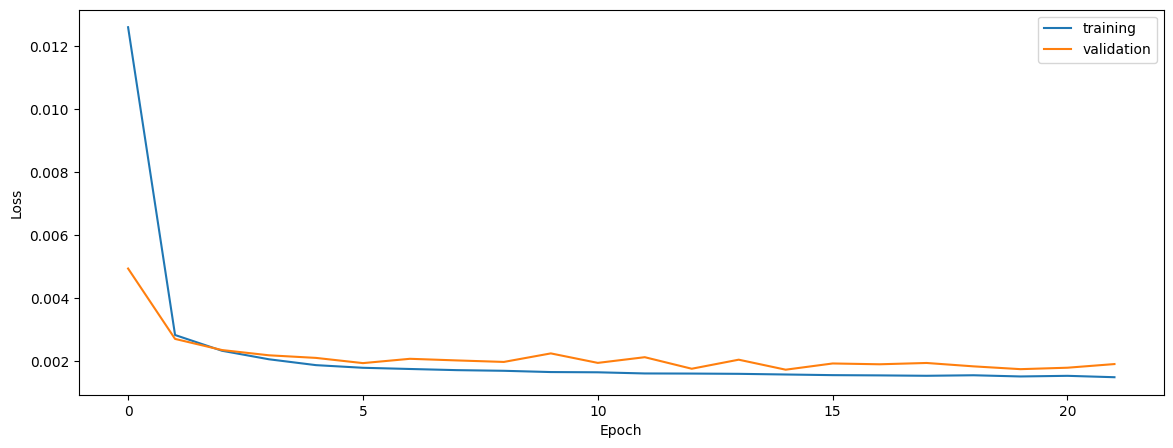

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getPearson(train[1],train[4]))
print(getPearson(val[1],val[4]))
print(getPearson(test[1],test[4]))

train
0.6126073009178127
0.6181728736209676
0.6299688502487331


In [8]:
print(props['space'])
print(getPearson(train[1],train[4],train[3][0]))
print(getPearson(val[1],val[4],val[3][0]))
print(getPearson(test[1],test[4],test[3][0]))

native
0.6132740459053218
0.6179799582434619
0.632156061580729


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getPearson(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getPearson(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getPearson(test[1][test[2]],test[4][test[2]],test[3][1]))

normalized
0.6253963501365788
0.6401718035268954
0.661180522987439


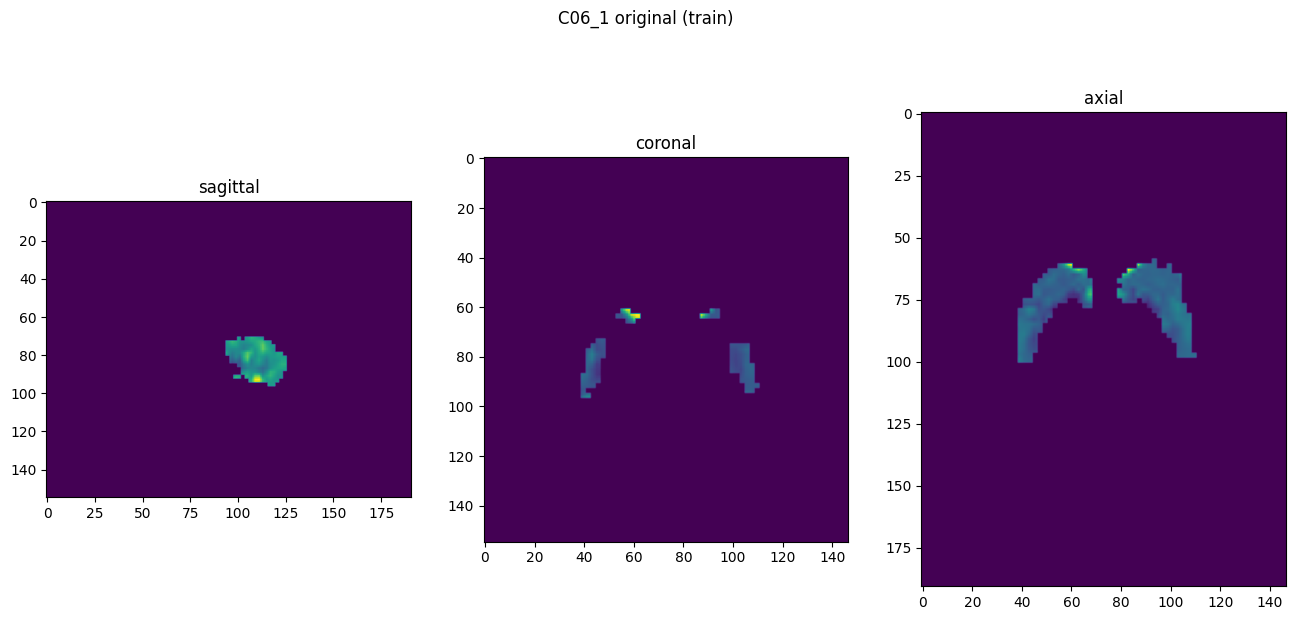

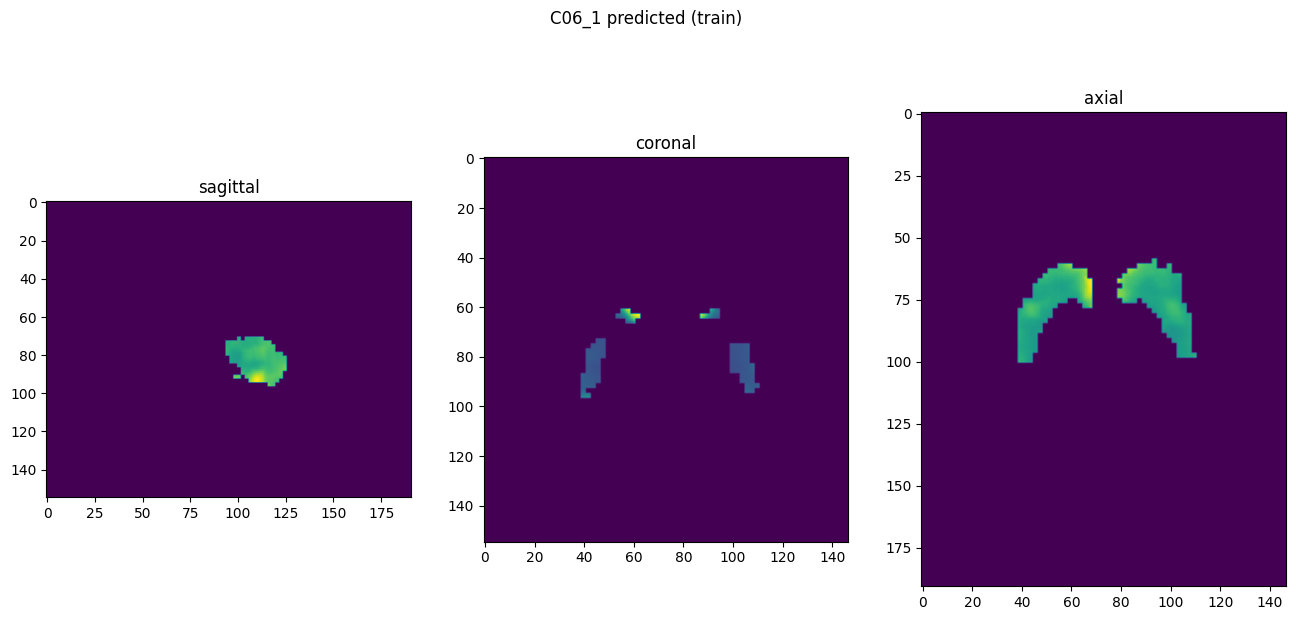

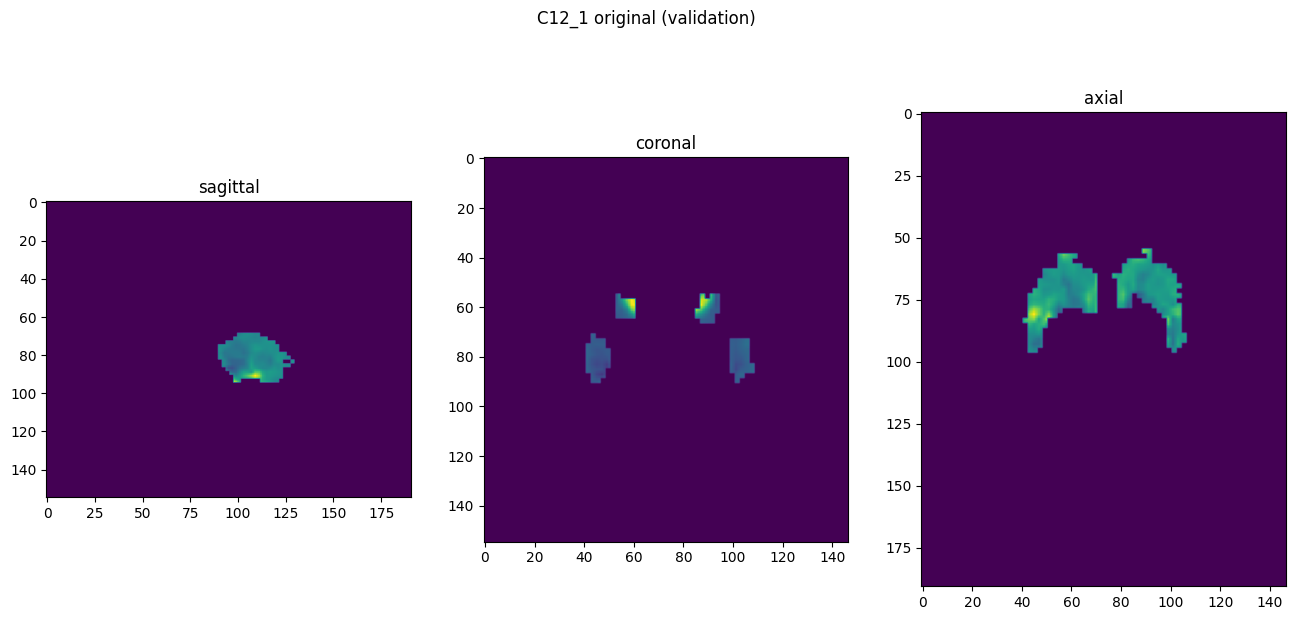

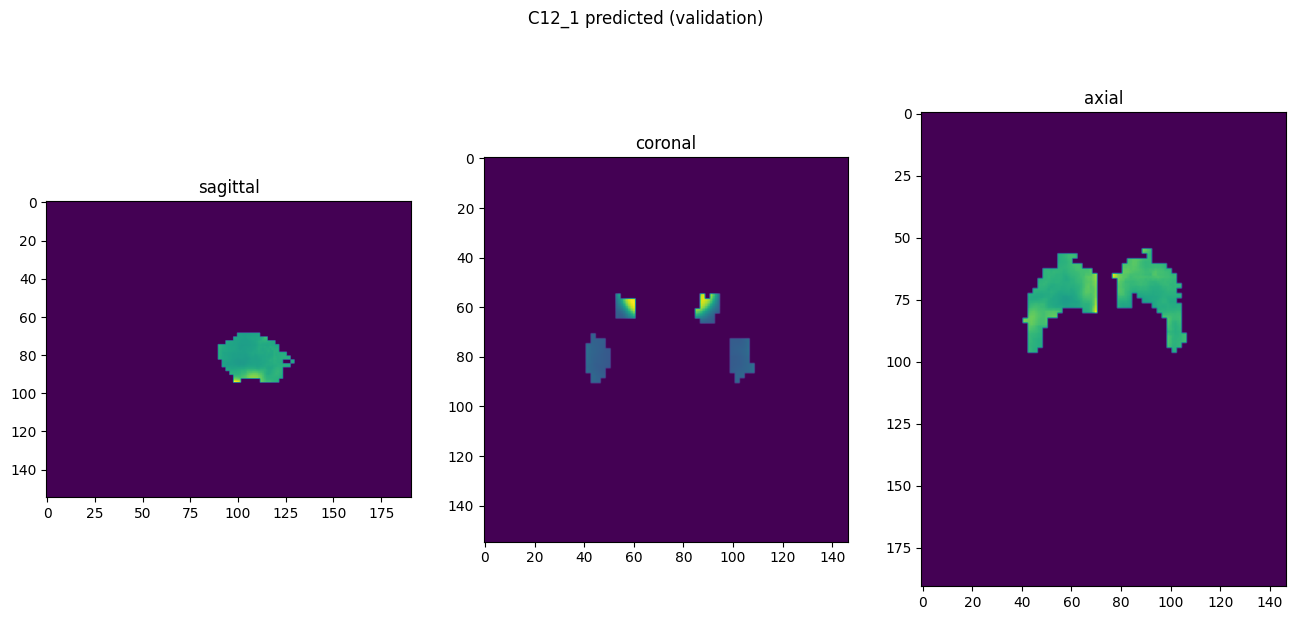

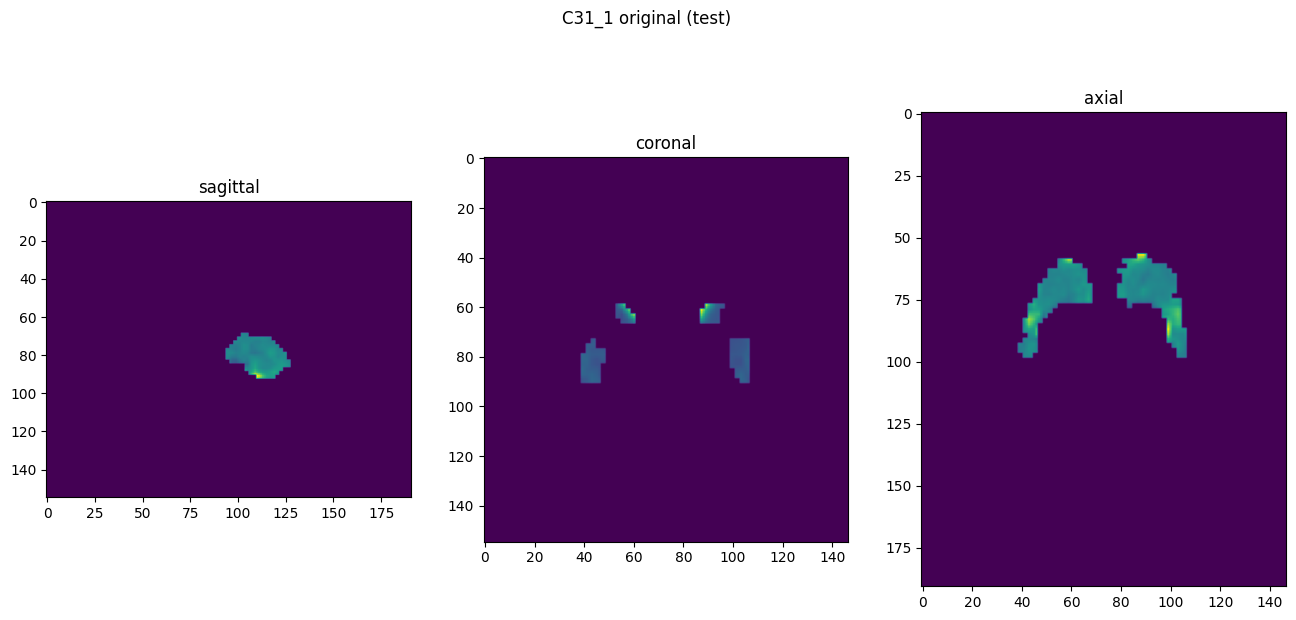

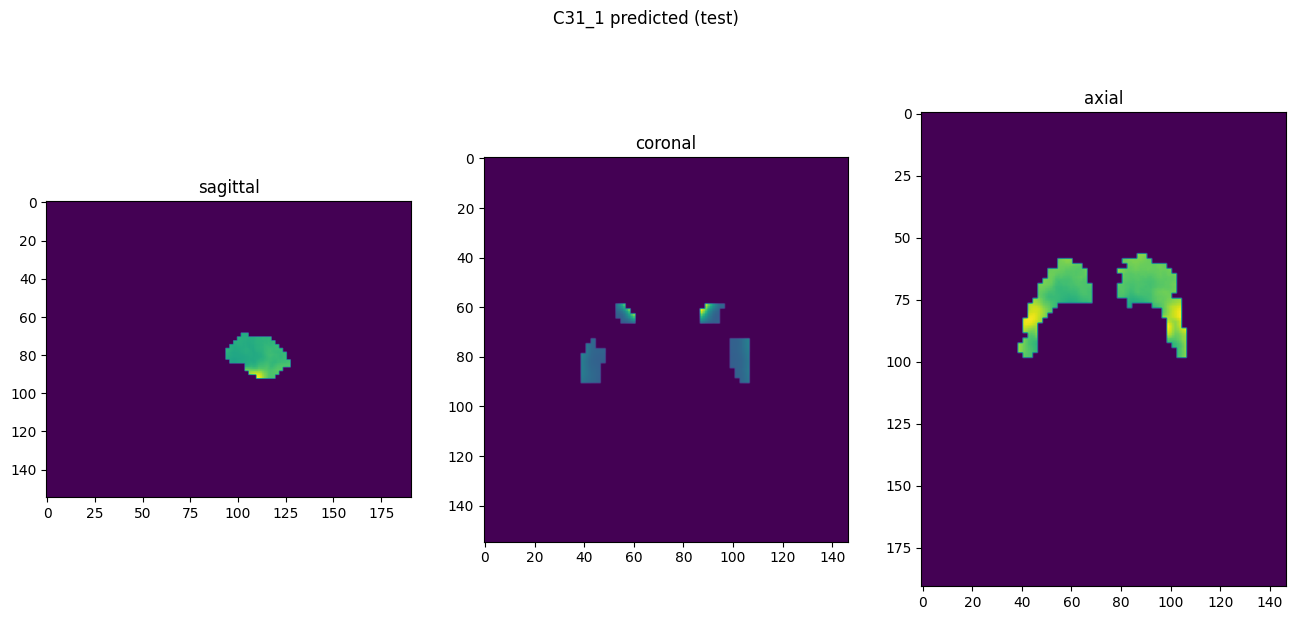

In [10]:
showResults(model, gen, threshold=None, background=False)